# Beta-Binomial model - Bayes' billiard - Estimating a probability

# C. Stan solution

# _Josep Fortiana  &emsp;&emsp;&emsp;&emsp;&emsp;   2023-03-06_

****
###### LaTeX macros
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\binomdist{\operatorname{Binomial}}$
$\def\berndist{\operatorname{Bernoulli}}$
$\def\betabinomdist{\operatorname{Beta-Binomial}}$
$\def\betadist{\operatorname{Beta}}$
$\def\betahat{\kern1.3pt\hat{\kern-1.3pt \beta}}$
$\def\borel{\operatorname{Borel}}$
$\def\cauchydist{\operatorname{Cauchy}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\dexpdist{\operatorname{DExp}}$
$\def\diag{\operatorname{diag}}$
$\def\eqdef{\stackrel{\text{def}}{\mskip3mu=\mskip3mu}}$
$\def\cE{\cal E}$
$\def\Ee{\operatorname{E}}$
$\def\expdist{\operatorname{Exponential}}$
$\def\fdist{\operatorname{F}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\halfcauchydist{\operatorname{Cauchy}^{+}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\invgammadist{\operatorname{InvGamma}}$
$\def\invwishartdist{\operatorname{InvWishart}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\def\indep{\perp{\mskip-16mu}\perp}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\DeclareMathOperator{\invgammadist}{InvGamma}$
$\newcommand{\KL}[2]{\operatorname{KL}(\mkern2mu#1\mkern2mu\mathrel\mid\mathrel{\mkern-8mu}\mid\mkern2mu#2\mkern2mu)}$
$\def\laplacedist{\operatorname{Laplace}}$
$\def\lognormaldist{\operatorname{Log-Normal}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinomial}$
$\def\N{\mathbb{N}}$
$\def\negbindist{\operatorname{NegativeBinomial}}$
$\def\normaldist{\operatorname{Normal}}$
$\def\Normaldist{\operatorname{MNormal}}$
$\def\cP{\cal P}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\prob{\operatorname{Prob}}$
$\def\R{\mathbb{R}}$ 
$\def\stilde{\tilde{s}}$ 
$\def\sqtilde{\tilde{s}{}^{2}}$ 
$\def\tdist{\operatorname{t}}$
$\def\u{\mathbb{1}}$
$\def\unifdist{\operatorname{Unif}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\Var{\operatorname{Var}}$
$\def\xbar{\kern1.3pt\overline{\kern-1.3pt x}}$
$\def\Xbar{\kern1.3pt\overline{\kern-1.3pt X}}$
$\def\yhat{\kern1.3pt\hat{\kern-1.3pt y}}$
$\def\Z{\mathbb{Z}}$
***

# Model description

A plain Beta-Bernoulli model as in the Bayes' billiard problem. 

Learn about an unknown probability $\theta$ from an independent sequence of $n$ Bernoulli experiments $Y_{1},\dots,Y_{n}$ iid $\sim\operatorname{Bern}(\theta)$, in $n_{1}$ of which the $1$ value was observed.

# Observed data

$n$ Bernoulli experiments, in $n_{1}$ of which a $1$ has been observed.

In [1]:
n=10
n1=3
y <- c(rep(1,n1),rep(0,n-n1))

In [2]:
y

[1] 1 1 1 0 0 0 0 0 0 0


# Treatment with Stan and `rstan`

Stan does:

1. Generate sequences of random numbers simulating pdf's, e.g., posterior, prior or posterior predictive pdf's.

2. "Outsource" out of R execution of repetitive (i.e., slow) tasks.

3. Using flavors of Markov Chain Monte Carlo (MCMC) simulation (usually). By default Stan uses the _No-U-Turn Sampler (NUTS)_ 
   version of _Hamiltonian Monte Carlo (HMC)._

4. Stan generates a C++ source file which is compiled (out of R) to an ad-hoc executable which generates the random sequences, which are then imported back into R. 

The `rstan` R package is an interface to Stan. See the  [Stan home page](http://mc-stan.org/)).

In [3]:
#install.packages("rstan", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(rstan,quietly=TRUE)


rstan version 2.26.13 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file



In [4]:
# Following directions:
# For execution on a local, multicore CPU with excess RAM we recommend calling
# options(mc.cores = parallel::detectCores()).
# To avoid recompilation of unchanged Stan programs, we recommend calling
# rstan_options(auto_write = TRUE)
parallel::detectCores()
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

[1] 12

## Specify model

#### Syntax similarities and differences between Stan and BUGS/JAGS

1. Stan requires declaration of numeric type, including specification of range limits when appropriate.

2. Statement lines in Stan end with a semicolon.
 
3. Comments in Stan are like in C++, a "//" to the end of line.
 
4. In Stan model statements are vectorized. Here the line `y~bernoulli(theta)` replaces the BUGS loop
     ```
     for ( i in 1:N){
         y[i]~dbern(theta)
         }
      ```
5. The formerly accepted Stan assignation (`<-`), as in R, has been deprecated.  Now the (`=`) symbol is mandatory.

In [5]:
modelString <- "
  data{
    int<lower=0> n ;
    int y[n] ; 
    real<lower=0> a ;
    real<lower=0> b ;
    }
  parameters{
    real<lower=0,upper=1> theta ;
    }
  model{
    theta ~ beta(a,b) ;
    y ~ bernoulli(theta) ; 
    }"

## Compile model and sample from the posterior pdf

In [6]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model( model_code=modelString ) 

In [7]:
# Specify data:
n <- 10 
n1 <- 3
a <- 2
b <- 5
y <- c(rep(1,n1),rep(0,n-n1))
dataList <- list(y=y,n=n,a=a,b=b)

In [8]:
# Generate posterior sample:
stanFit <- sampling( object=stanDso, 
                     data = dataList, 
                     chains = 3,
                     iter = 2000, 
                     warmup = 200, 
                     thin = 2)

In [9]:
post.a<- a + n1
post.b <-b + n -n1
post.a
post.b

[1] 5

[1] 12

In [10]:
Teor.post.mean<- post.a/ (post.a+post.b)
round(Teor.post.mean,3)

[1] 0.294

In [11]:
S<-summary(stanFit)
round(S$summary,3)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
theta,0.295,0.002,0.106,0.114,0.216,0.288,0.366,0.519,1803.42,1
lp__,-10.799,0.016,0.701,-12.816,-10.949,-10.544,-10.348,-10.299,1996.55,1


## Diagnostic plots: traceplot, autocorrelation function

### Traceplot

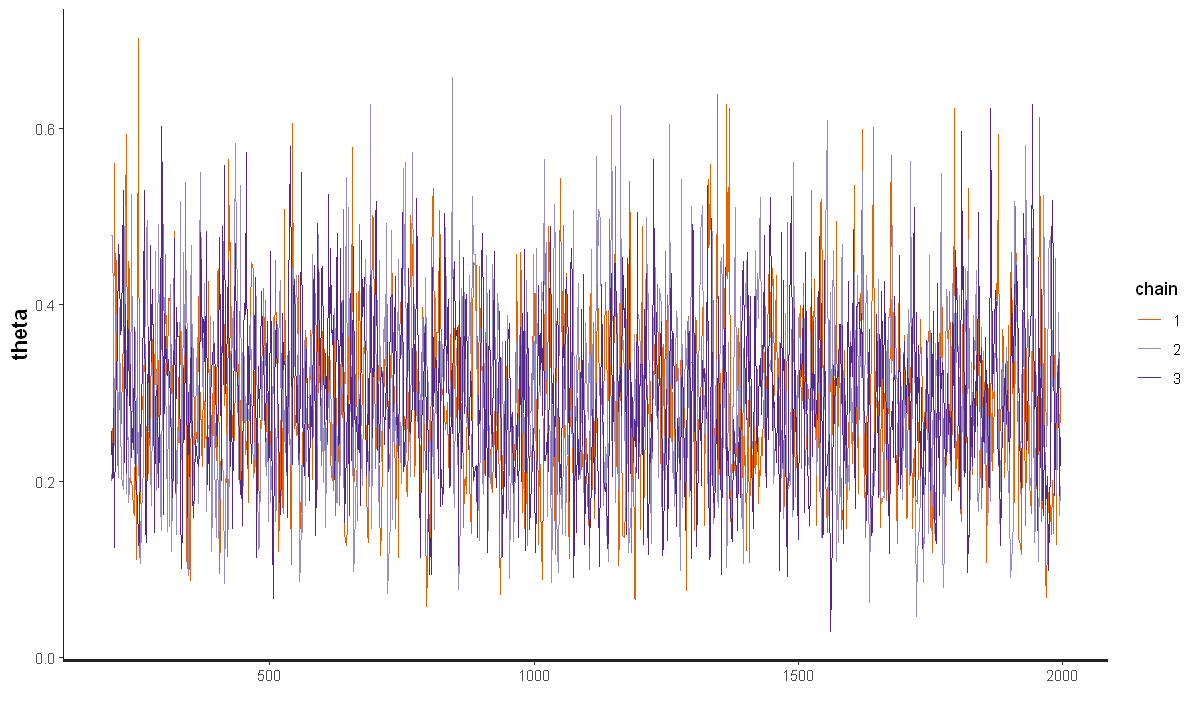

In [12]:
options(repr.plot.width=10,repr.plot.height=6)
traceplot(stanFit,pars=c("theta"))

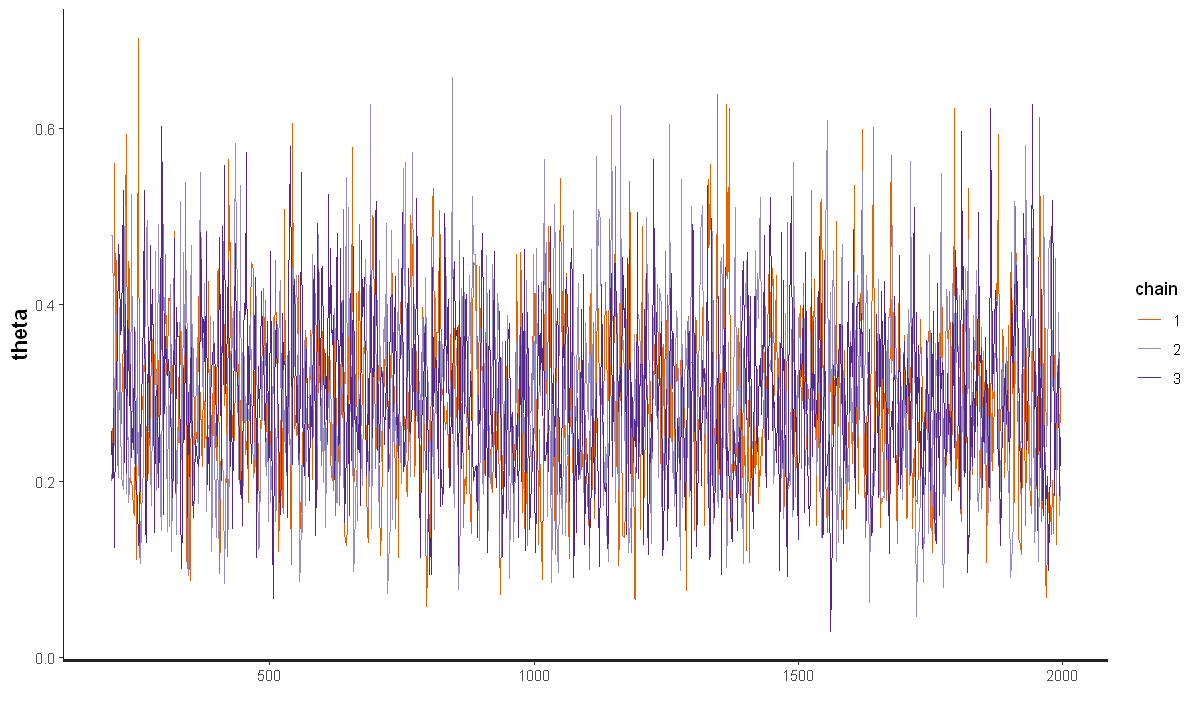

In [13]:
# Alternative syntax
options(repr.plot.width=10,repr.plot.height=6)
stan_trace(stanFit,pars=c("theta"))

### Autocorrelation plot

Warning message:
"Computation failed in `stat_summary()`
Caused by error in `get()`:
! object 'mean_se' of mode 'function' was not found"


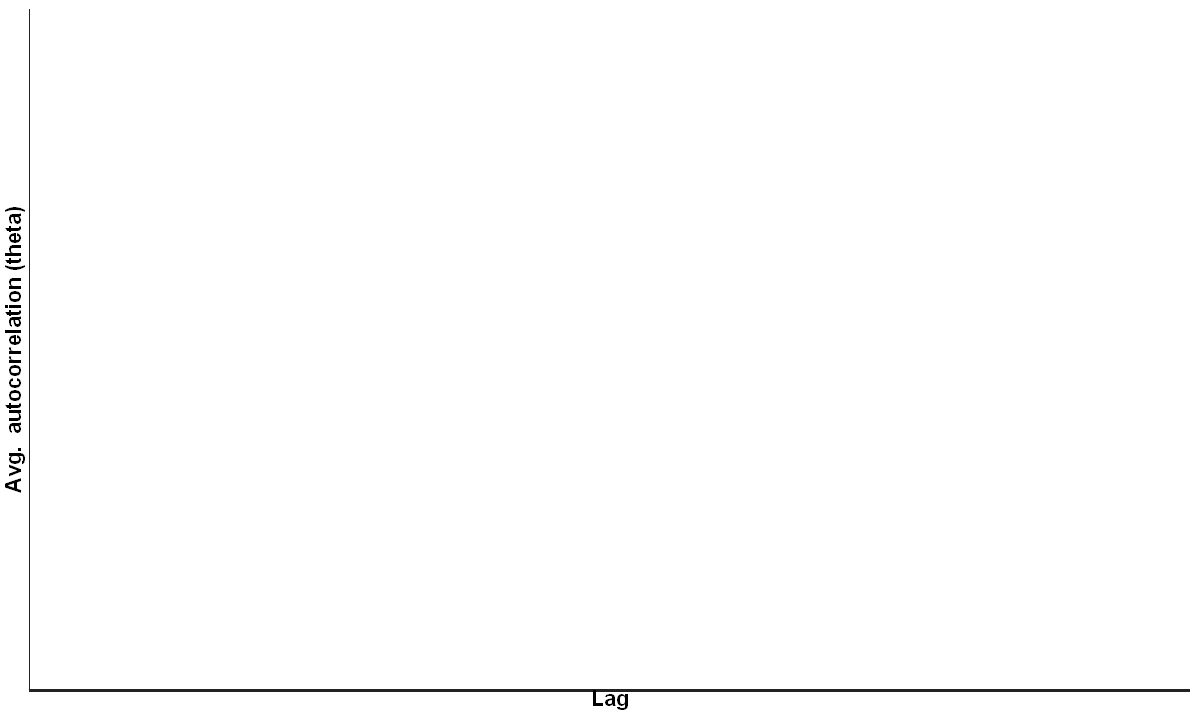

In [14]:
options(repr.plot.width=10,repr.plot.height=6)
stan_ac(stanFit,pars=c("theta"))

## Analysis of posterior pdf properties

### Posterior credible interval 

ci_level: 0.9 (90% intervals)

outer_level: 0.95 (95% intervals)



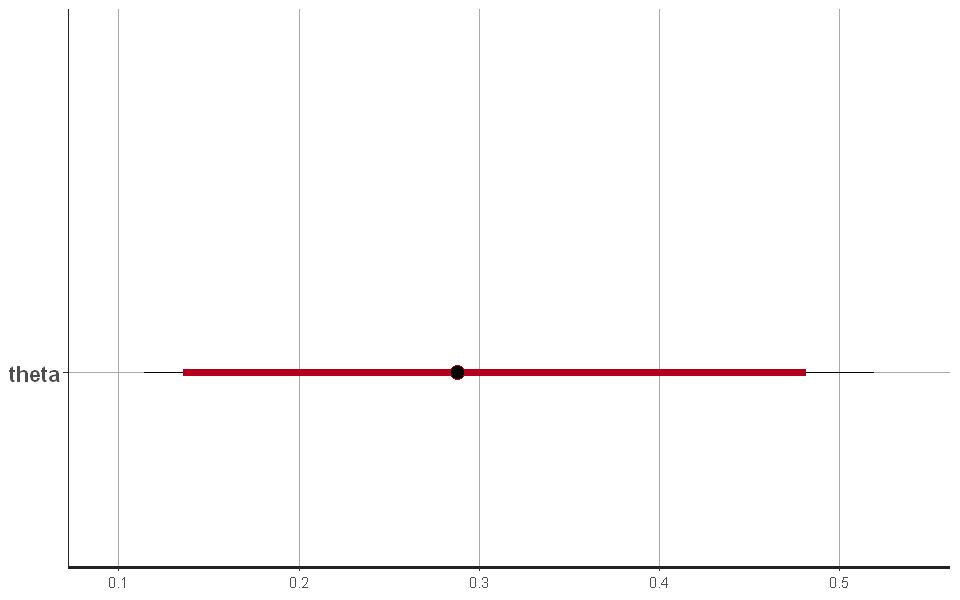

In [15]:
# Credible interval (see syntax in the stan package help)
options(repr.plot.width=8,repr.plot.height=5)
plot(stanFit,pars=c("theta"),ci_level = 0.90)

### Posterior histogram

Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.
ℹ The deprecated feature was likely used in the rstan package.
  Please report the issue at <https://github.com/stan-dev/rstan/issues/>."


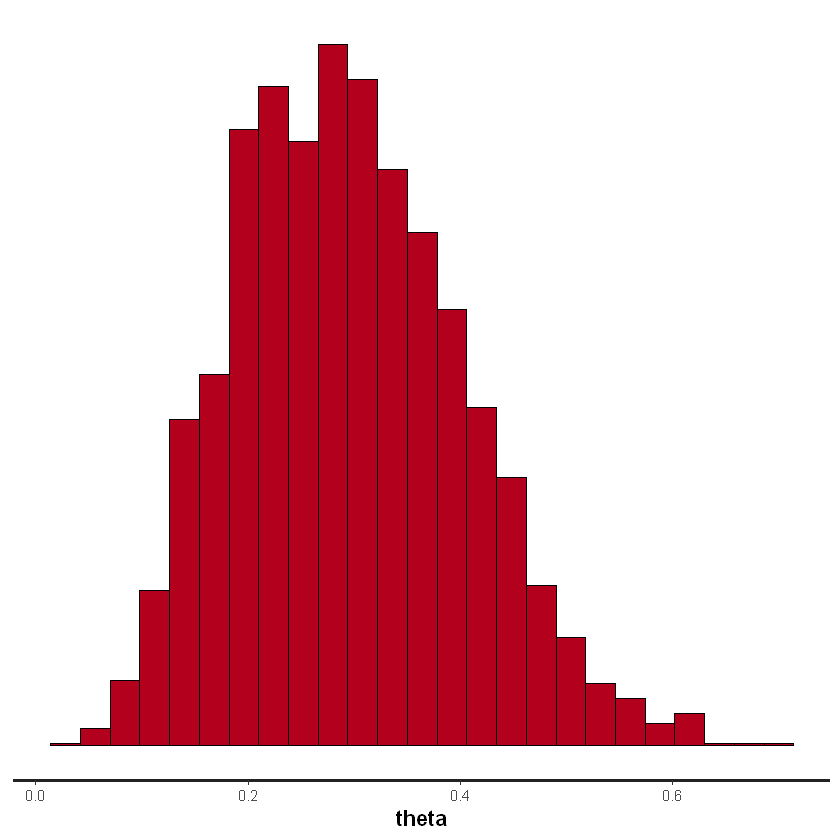

In [16]:
options(repr.plot.width=7,repr.plot.height=7)
stan_hist(stanFit,pars=c("theta"),bins=25)

### Posterior density

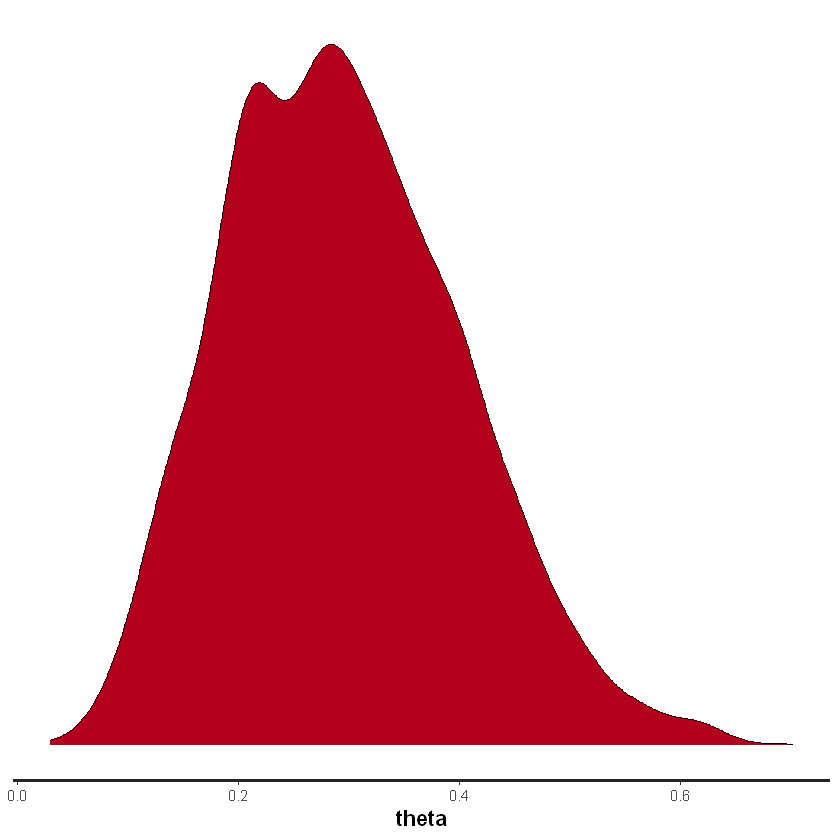

In [17]:
options(repr.plot.width=7,repr.plot.height=7)
stan_dens(stanFit,pars=c("theta"))

# Same diagrams with the `bayesplot` package

In [18]:
#install.packages("bayesplot", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(bayesplot,quietly=TRUE)

This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting



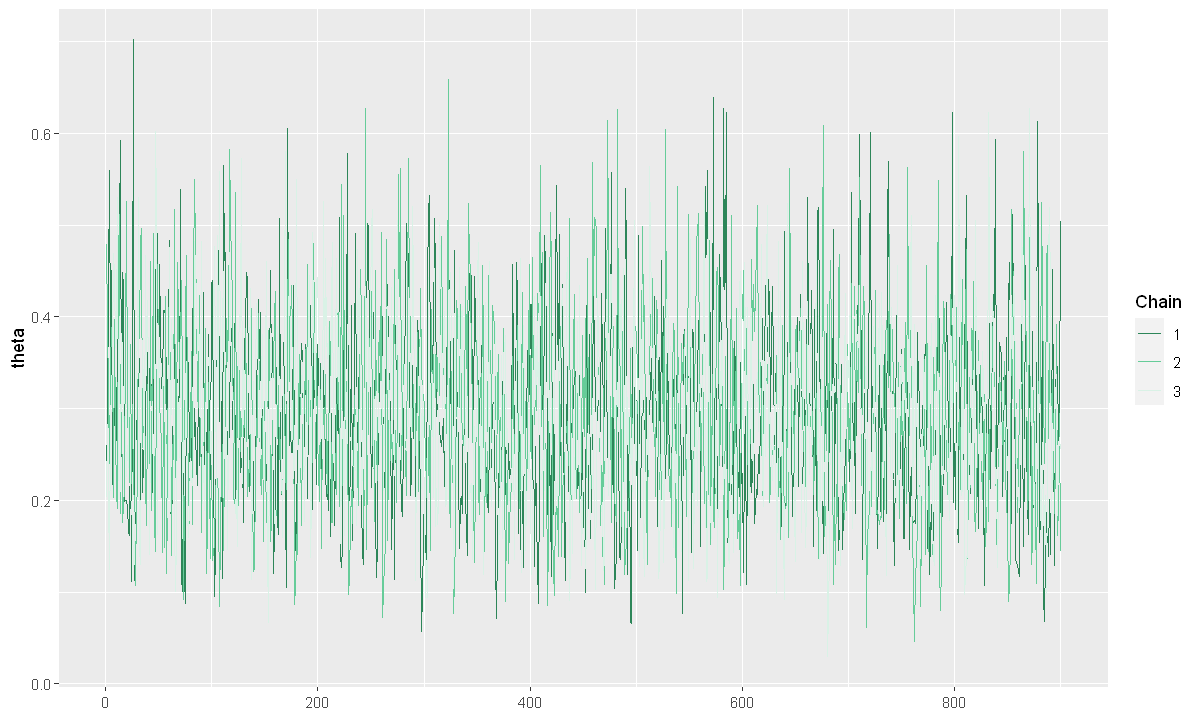

In [19]:
color_scheme_set("green")
options(repr.plot.width=10,repr.plot.height=6)
mcmc_trace(stanFit, pars = c("theta"))

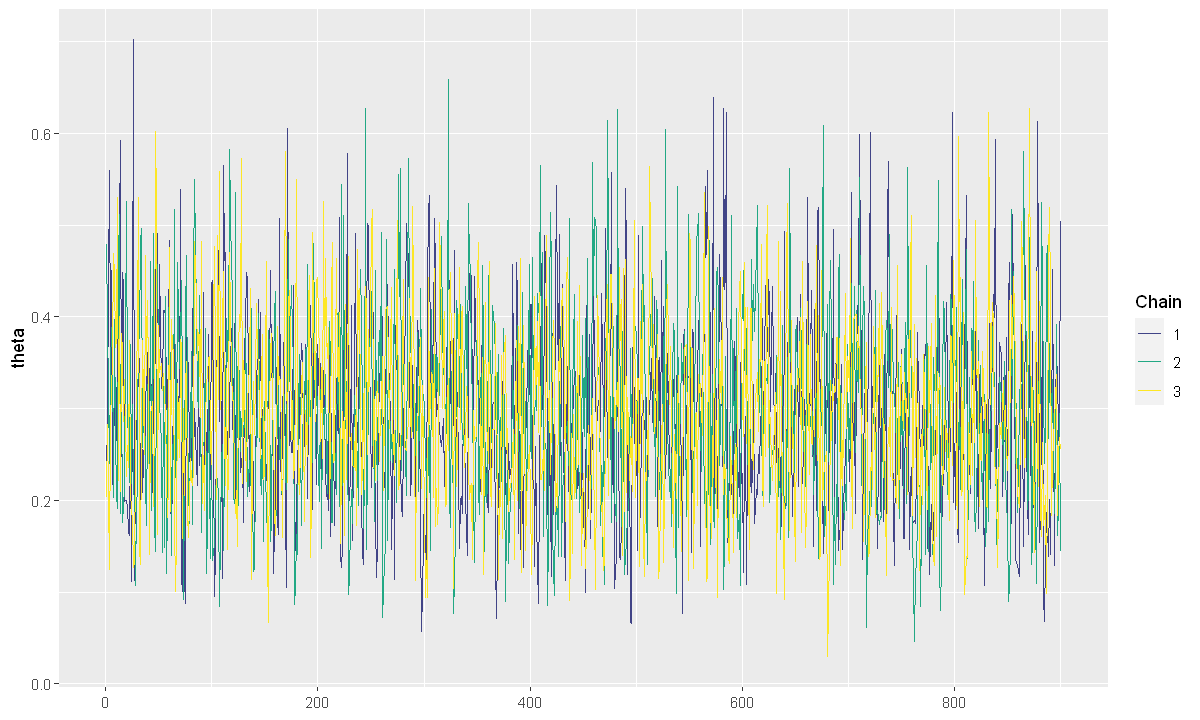

In [20]:
color_scheme_set("viridis")
options(repr.plot.width=10,repr.plot.height=6)
mcmc_trace(stanFit, pars = c("theta"))

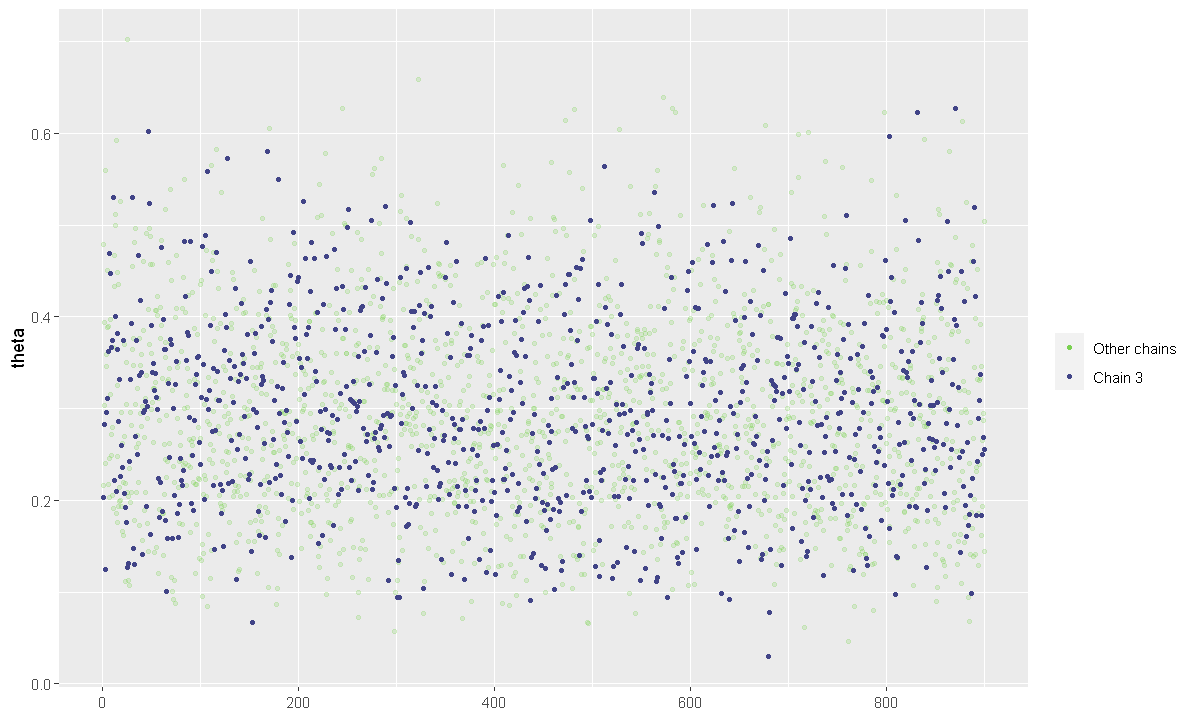

In [21]:
options(repr.plot.width=10,repr.plot.height=6)
mcmc_trace_highlight(stanFit, pars = c("theta"), highlight = 3)

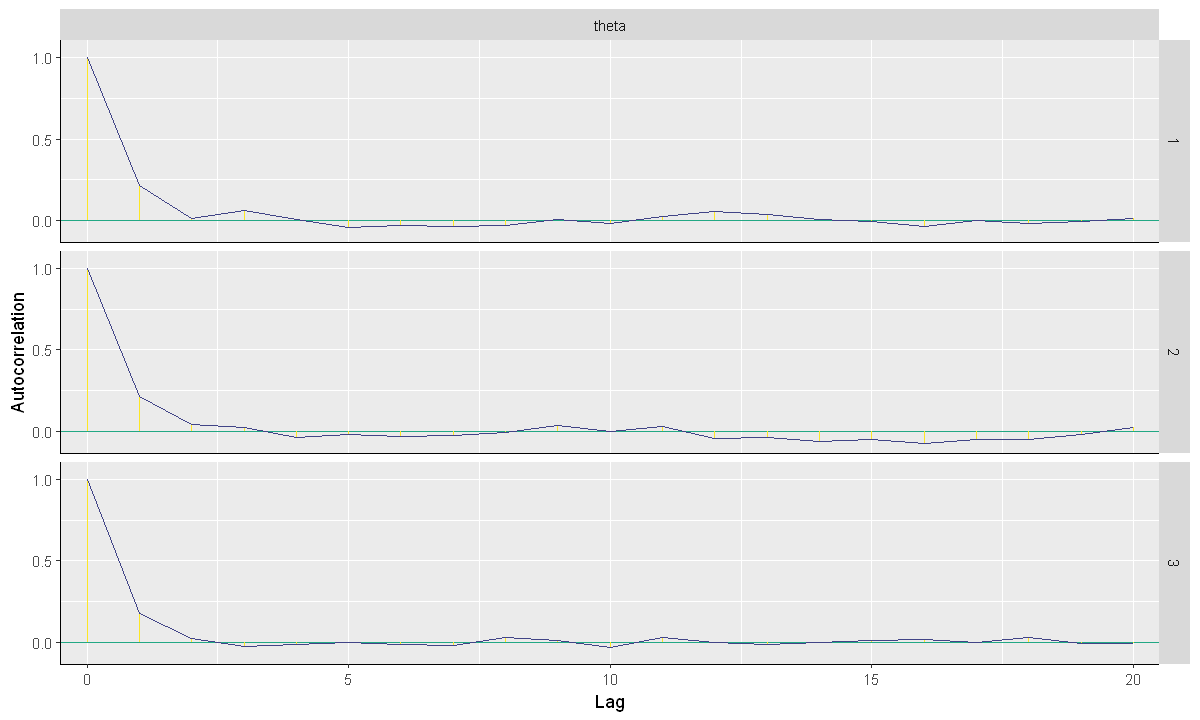

In [22]:
options(repr.plot.width=10,repr.plot.height=6)
mcmc_acf(stanFit,pars=c("theta"))

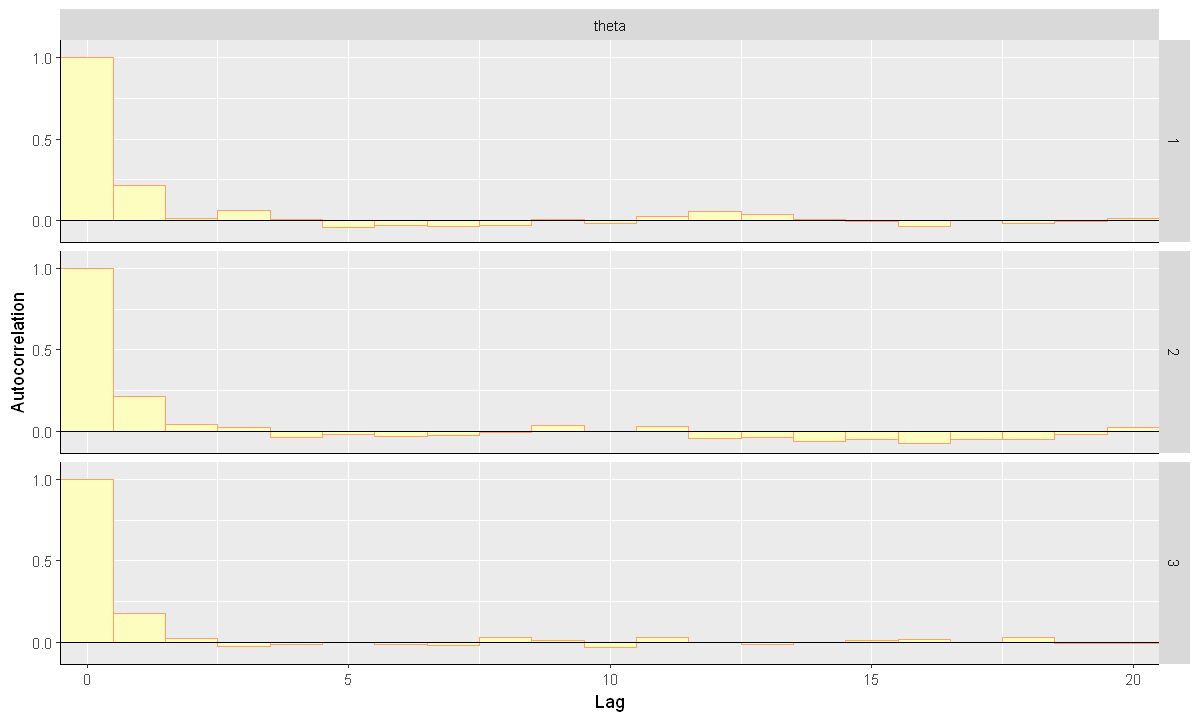

In [23]:
color_scheme_set("viridisA")
options(repr.plot.width=10,repr.plot.height=6)
mcmc_acf_bar(stanFit,pars=c("theta"))

## Analysis of posterior pdf properties

### Posterior credible interval 

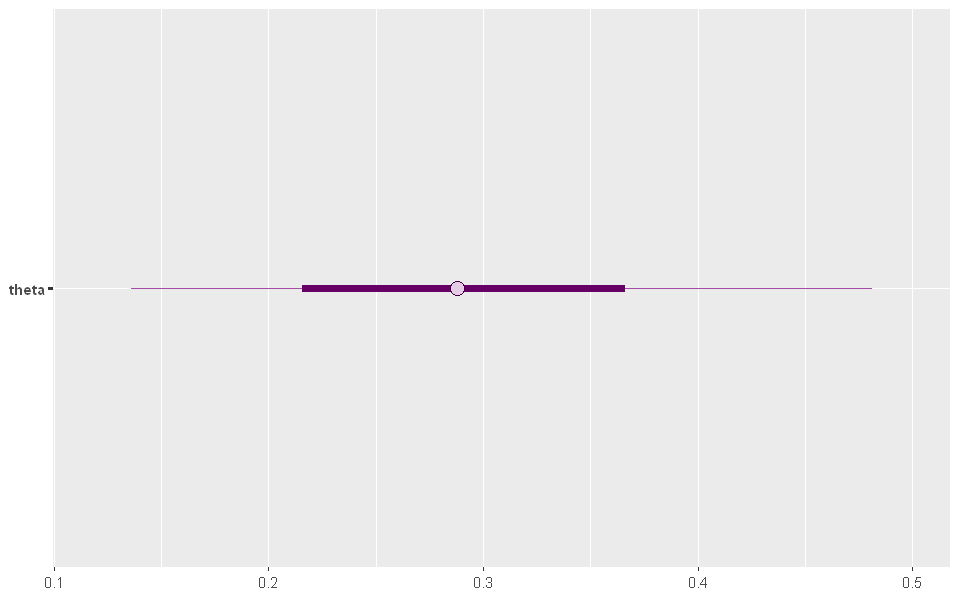

In [24]:
color_scheme_set("purple")
options(repr.plot.width=8,repr.plot.height=5)
mcmc_intervals(stanFit, pars = c("theta"))
# Defaults are
# prob = 0.5,
# prob_outer = 0.9,

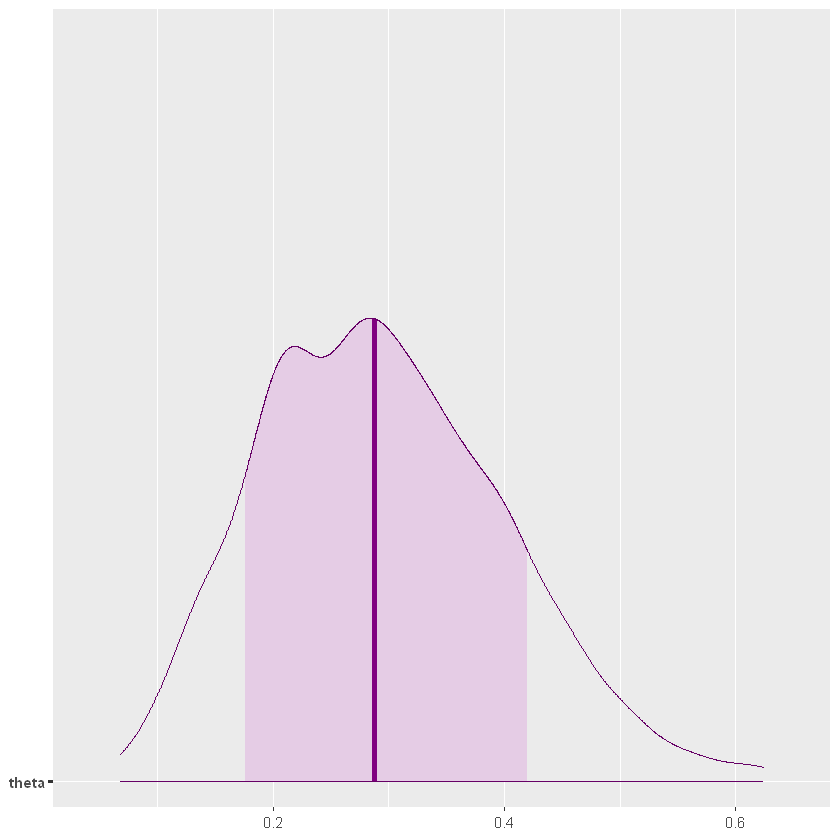

In [25]:
options(repr.plot.width=7,repr.plot.height=7)
mcmc_areas(stanFit, pars = c("theta"),prob=0.75,prob_outer=0.995)

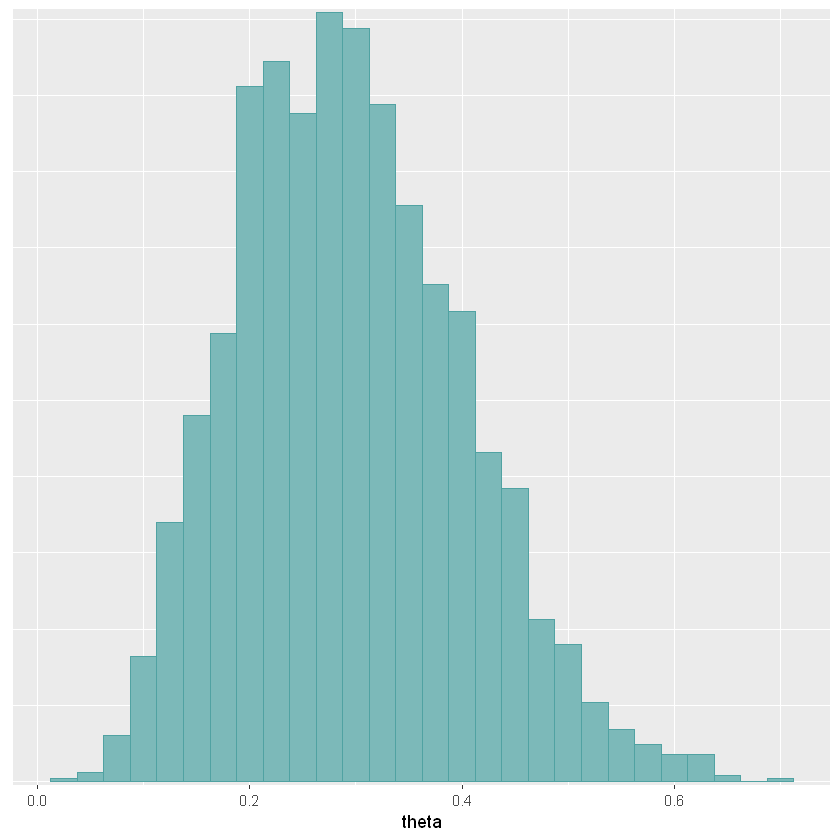

In [26]:
color_scheme_set("teal")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_hist(stanFit, pars = c("theta"),binwidth=0.025)

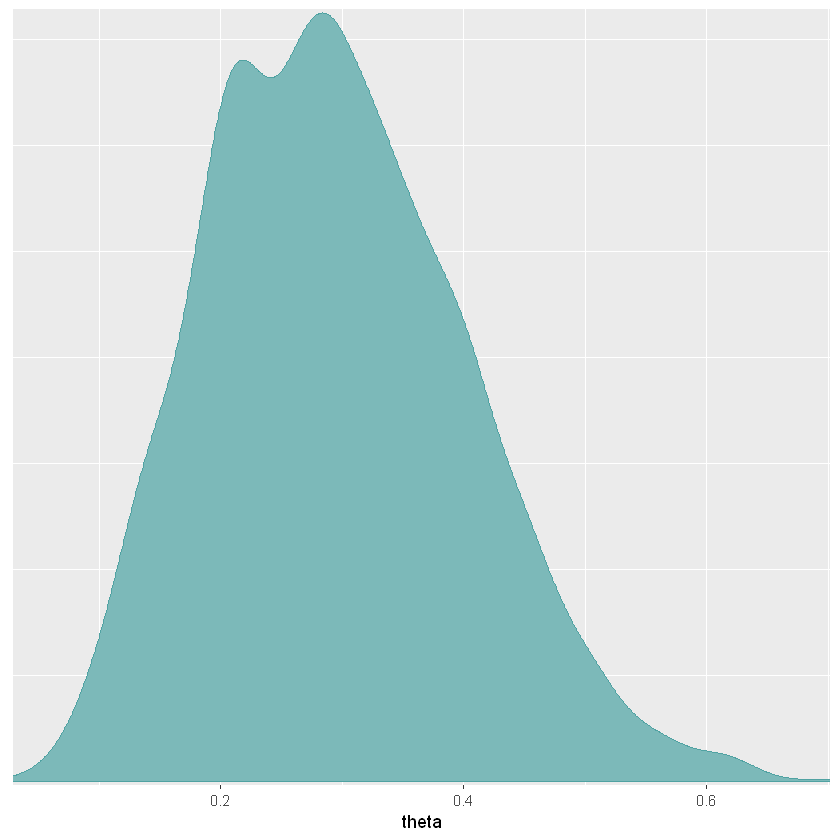

In [27]:
options(repr.plot.width=7,repr.plot.height=7)
mcmc_dens(stanFit, pars = c("theta"))

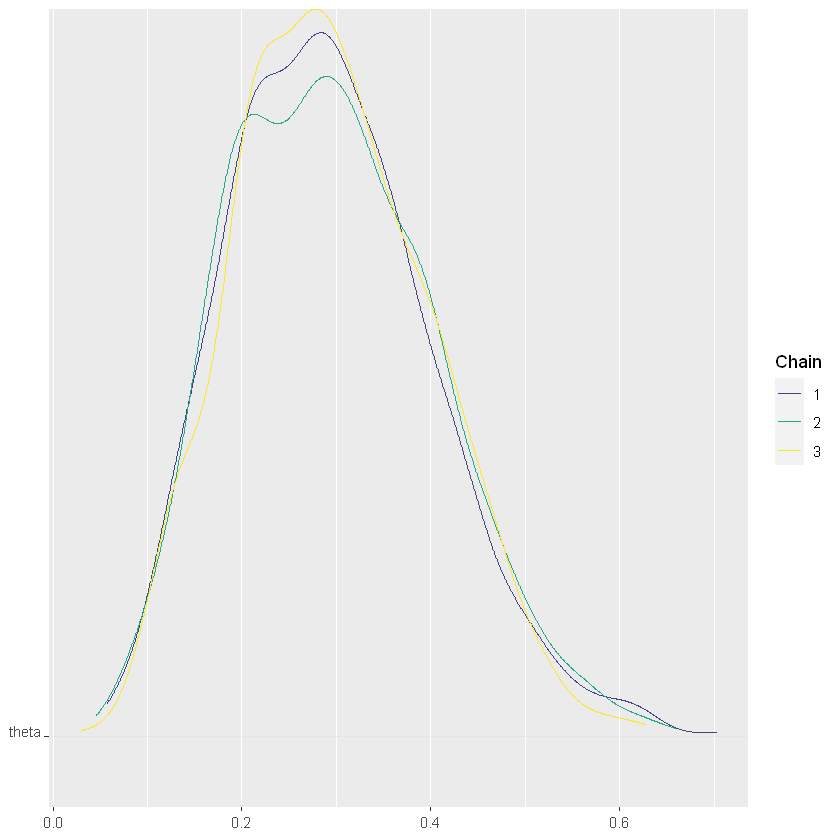

In [28]:
color_scheme_set("viridisD")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_dens_chains(stanFit, pars = c("theta"))

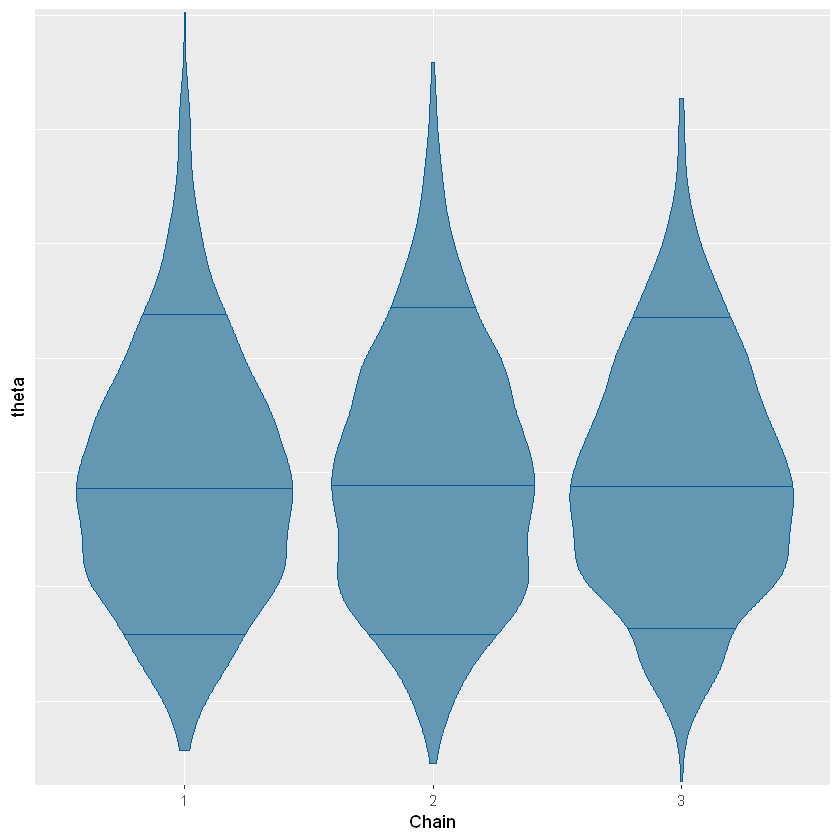

In [29]:
color_scheme_set("blue")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_violin(stanFit, pars = c("theta"))

# Prior predictive simulation

In [30]:
model_PriorPred.String = "
  data{
    int<lower=0> n ;
    //int y[n] ;              //NO data needed
    real<lower=0> a ;
    real<lower=0> b ;
    }
  parameters{
    real<lower=0,upper=1> theta ;
    }
  model{
    theta ~ beta(a,b) ;
    //y ~ bernoulli(theta) ;   //NO data needed
    }
   generated quantities{
        int<lower=0,upper=n> n1_PriorPred ; 
        n1_PriorPred = binomial_rng(n,theta) ; 
    }"

## Compile model and draw samples

In [31]:
# Translate model to C++ and compile to DSO:
stanDso_PriorPred <- stan_model( model_code=model_PriorPred.String ) 

In [32]:
# Specify data:
n <- 10 
# n1 <- 3
a <- 2
b <- 5
dataList_PriorPred = list(n=n,a=a,b=b)

In [33]:
# Generate sample:
stanFit_PriorPred <- sampling( object=stanDso_PriorPred, 
                     data = dataList_PriorPred, 
                     chains = 3,
                     iter = 3000, 
                     warmup = 200, 
                     thin = 1)

In [34]:
prior_theta_mean<-a/(a+b)
round(prior_theta_mean,3)

[1] 0.286

In [35]:
S<-summary(stanFit_PriorPred)
round(S$summary,3)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
theta,0.290,0.003,0.158,0.046,0.168,0.269,0.394,0.640,3366.016,1.001
n1_PriorPred,2.912,0.031,2.074,0.000,1.000,3.000,4.000,8.000,4604.196,1.000
lp__,-4.710,0.014,0.729,-6.833,-4.878,-4.427,-4.244,-4.189,2583.849,1.000


In [36]:
n1_PriorPred<-as.numeric(extract(stanFit_PriorPred,pars='n1_PriorPred')$n1_PriorPred)

In [37]:
str(n1_PriorPred)

 num [1:8400] 4 1 4 3 2 4 4 1 4 2 ...


#### R language quirk:

I would like to use `table()` to obtain the absolute, then relative frequencies in this sequence.

The output of `table()` omits bins with 0 frequency.

Thus I will not be able to compare it with the theoretical probabilities.

In [38]:
T_PriorPred.0<-table(n1_PriorPred)
str(T_PriorPred.0)
T_PriorPred.0

 'table' int [1:11(1d)] 962 1437 1654 1352 1152 833 486 305 147 61 ...
 - attr(*, "dimnames")=List of 1
  ..$ n1_PriorPred: chr [1:11] "0" "1" "2" "3" ...


n1_PriorPred
   0    1    2    3    4    5    6    7    8    9   10 
 962 1437 1654 1352 1152  833  486  305  147   61   11 

#### R language quirk (continued):

If I could be sure that all zeros appear at the end of the sequence I could append tem by hand.

A better alternative is to use `tabulate()`, which lists all frequencies for each of the `nbins` I specify.

Still, `tabulate()` requires **positive integers** hence I must increaseby one `n1_PostPred` before calling it.

In [39]:
T_PriorPred<-tabulate(n1_PriorPred+1,nbins=n+1)
#str(T_PriorPred)
T_PriorPred

[1]  962 1437 1654 1352 1152  833  486  305  147   61   11

In [40]:
length(T_PriorPred) # must be equal to n+1
sum(T_PriorPred)

[1] 11

[1] 8400

In [41]:
# Table of relative frequencies (proportions)
f_PriorPred<-as.numeric(T_PriorPred/sum(T_PriorPred))
#round(f_PriorPred,3)
#str(f_PriorPred)

### Compare the sampled simulated prior predictive pmf and the theoretical one

From the theory, it is known that in a model with Binomial likelihood $X\sim\binomdist(n\,|\,\theta)$ and Beta prior $\theta\sim\betadist(a,b)$, the prior predictive distribution is a Beta-Binomial (see Wikipedia).

$$
    \betabinomdist(n,a,b)
$$

In [42]:
#install.packages("extraDistr",dependencies=TRUE,repos= "https://cloud.r-project.org")
require("extraDistr",quietly=TRUE)

In [43]:
# Beta-Binomial probabilities, to be compared to the above relative frequencies
x.vals<-0:n
g<-dbbinom(x.vals,size=n,alpha=a,beta=b)
#round(g,3)
#str(g)

In [44]:
# For a uniform prior both vectors approach the probabilities of a discrete uniform distribution
yfg<-cbind(f_PriorPred,g)
#round(t(yfg),3)

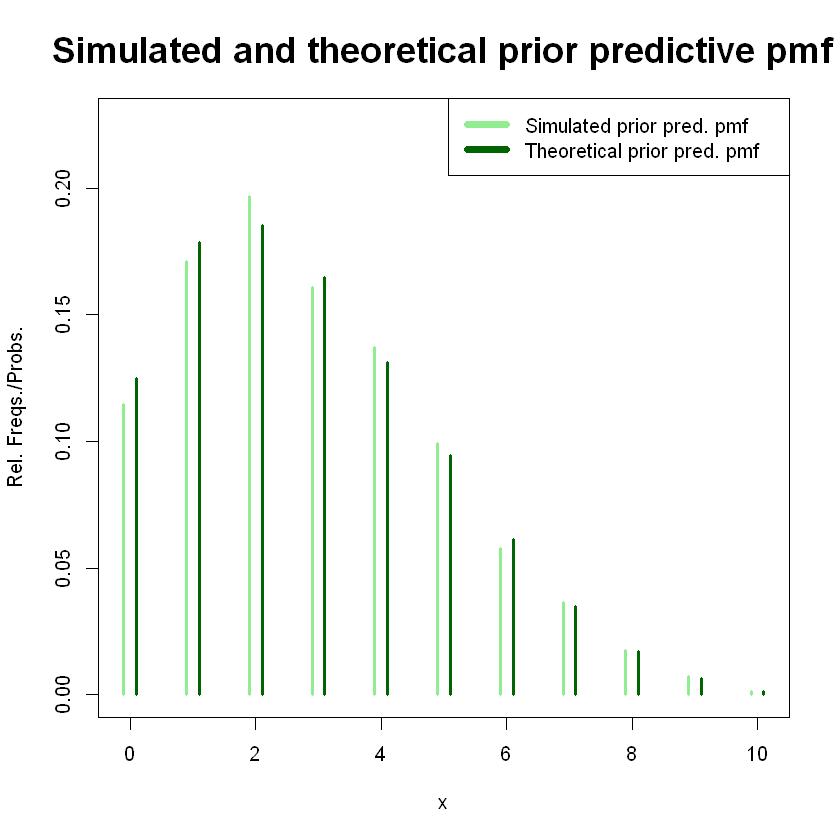

In [45]:
options(repr.plot.width=7,repr.plot.height=7)
y.max<-max(yfg)*1.15
matplot(x=cbind(x.vals-0.1,x.vals+0.1),y=yfg,type="h",lwd=3, lty=1,col=c("LightGreen","DarkGreen"),
        ylim=c(0,y.max),xlab="x",ylab="Rel. Freqs./Probs.",
        main="Simulated and theoretical prior predictive pmf",cex.main=1.8)
legend("topright",legend=c("Simulated prior pred. pmf","Theoretical prior pred. pmf"),
       lwd=6, lty=1,col=c("LightGreen","DarkGreen"))

# Posterior predictive simulation

A new experiment is performed, `New_n` trials, in which we will register the number `n1_PostPred` of ones.

The posterior predictive distribution is that of `n1_PostPred`, given the previously observed `n1` successes out of `n`trials.

We can enter just `n1`  instead of the full `y` vector.

In [46]:
model_PostPred.String = "
  data{
    int<lower=0> n ;
    int<lower=0,upper=n> n1 ; 
    real<lower=0> a ;
    real<lower=0> b ;
    int<lower=0> New_n ;  // New experiment to be performed
    }
  parameters{
    real<lower=0,upper=1> theta ;
    }
  model{
    theta ~ beta(a,b) ;
    n1 ~ binomial(n,theta) ;   //Now we enter y
    }
   generated quantities{
        int<lower=0,upper=New_n> n1_PostPred ; 
        n1_PostPred = binomial_rng(New_n,theta) ; 
    }"

## Compile model and draw samples

In [47]:
# Translate model to C++ and compile to DSO:
stanDso_PostPred <- stan_model( model_code=model_PostPred.String ) 

In [48]:
# Specify data:
n <- 10 
n1 <- 3
a <- 2
b <- 5
New_n<-40   # We will perform New_n trials
dataList_PostPred = list(n=n,n1=n1,a=a,b=b,New_n=New_n)

In [49]:
# Generate posterior sample:
stanFit_PostPred <- sampling( object=stanDso_PostPred, 
                     data = dataList_PostPred, 
                     chains = 3,
                     iter = 10000, 
                     warmup = 200, 
                     thin = 1)

In [50]:
S<-summary(stanFit_PostPred)
round(S$summary,3)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
theta,0.295,0.001,0.107,0.110,0.216,0.287,0.364,0.524,10458.05,1
n1_PostPred,11.807,0.045,5.137,3.000,8.000,11.000,15.000,23.000,12996.85,1
lp__,-10.816,0.007,0.732,-12.914,-10.985,-10.530,-10.351,-10.299,12260.59,1


In [51]:
n1_PostPred<-as.numeric(extract(stanFit_PostPred,pars='n1_PostPred')$n1_PostPred)
str(n1_PostPred)

 num [1:29400] 10 12 8 19 8 10 4 10 14 9 ...


In [52]:
min(n1_PostPred)

[1] 0

In [53]:
max(n1_PostPred)

[1] 34

#### R language quirk:  (just as in the prior predictive above)

I would like to use `table()` to obtain the absolute, then relative frequencies in this sequence.

The output of `table()` omits bins with 0 frequency.

Thus I will not be able to compare it with the theoretical probabilities.

In [54]:
T_PostPred.0<-table(n1_PostPred)
str(T_PostPred.0)
T_PostPred.0

 'table' int [1:34(1d)] 30 134 306 541 841 1130 1599 1772 1981 2098 ...
 - attr(*, "dimnames")=List of 1
  ..$ n1_PostPred: chr [1:34] "0" "1" "2" "3" ...


n1_PostPred
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
  30  134  306  541  841 1130 1599 1772 1981 2098 2218 2205 2162 2047 1947 1606 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
1464 1184 1006  753  672  499  370  280  191  153   72   58   32   27   10    7 
  32   34 
   4    1 

#### R language quirk (continued):

If I could be sure that all zeros appear at the end of the sequence I could append tem by hand.

A better alternative is to use `tabulate()`, which lists all frequencies for each of the `nbins` I specify.

Still, `tabulate()` requires **positive integers** hence I must increaseby one `n1_PriorPred` before calling it.

In [55]:
T_PostPred<-tabulate(n1_PostPred+1,nbins=New_n+1)
#str(T_PostPred)
#T_PostPred

In [56]:
length(T_PostPred)
sum(T_PostPred)

[1] 41

[1] 29400

In [57]:
# Table of relative frequencies (proportions)
f_PostPred<-as.numeric(T_PostPred/sum(T_PostPred))
#round(f_PostPred,3)
#str(f_PostPred)

### Compare the sampled simulated prior predictive pmf and the theoretical one

From the theory, it is known that in a model with Binomial likelihood $X\sim\binomdist(n\,|\,\theta)$, Beta prior $\theta\sim\betadist(a,b)$, 
given the observed $n_{1}$ successes (or 1's, or ball on the right of the cue ball, etc.) out of $n$ trials, the posterior pdf of $\theta$,
$\theta\CondTo n_{1}\sim\betadist(a',b')$,  where $a'=a+n_{1}$, $b'=b+n-n_{1}$.

Now if we want to predict the output of a new batch of $n^{\text{New}}$ trials, the posterior predictive distribution
for the resulting number of successes is a Beta-Binomial:

$$
    \big(n_{1}^{\text{PostPred}}\CondTo n_{1}\big)\mskip10mu\sim\mskip10mu\betabinomdist(n^{\text{New}},a',b')
    \mskip10mu=\mskip10mu\betabinomdist(n^{\text{New}},a+n_{1},b+n-n_{1})
$$

In [58]:
#install.packages("extraDistr",dependencies=TRUE,repos= "https://cloud.r-project.org")
require("extraDistr")

In [59]:
# Beta-Binomial probabilities, to be compared to the above relative frequencies
x.vals<-0:New_n
g<-dbbinom(x.vals,size=New_n,alpha=a+n1,beta=b+n-n1)
#round(g,3)
#str(g)

In [60]:
# For a uniform prior both vectors approach the probabilities of a discrete uniform distribution
yfg<-cbind(f_PostPred,g)
#round(t(yfg),3)

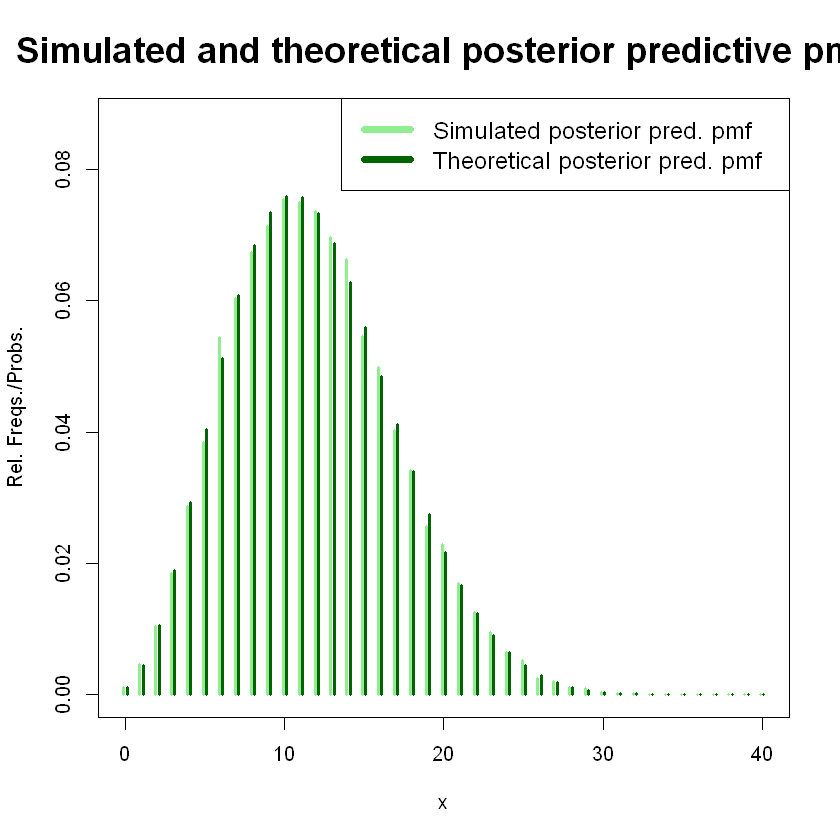

In [61]:
options(repr.plot.width=7,repr.plot.height=7)
y.max<-max(yfg)*1.15
matplot(x=cbind(x.vals-0.1,x.vals+0.1),y=yfg,type="h",lwd=3, lty=1,col=c("LightGreen","DarkGreen"),
        ylim=c(0,y.max),xlab="x",ylab="Rel. Freqs./Probs.",
        main="Simulated and theoretical posterior predictive pmf",cex.main=1.8)
legend("topright",legend=c("Simulated posterior pred. pmf","Theoretical posterior pred. pmf"),
       lwd=6, lty=1,cex=1.2,col=c("LightGreen","DarkGreen"))